https://www.nature.com/articles/s41556-020-00613-6

In [1]:
import sys, os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))  

In [2]:
from scrna_pipeline.h5ad_builders import raw_matrix_to_h5ad

/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
raw_to_h5ad = raw_matrix_to_h5ad("/Users/alahi.irfan/Desktop/Local_workspace/Data/Chen_NatureCellBiol_2021/GSE141445_RAW/GSM4203181_data.raw.matrix.txt.gz",
                                                               genes_are_rows=True, sample_from_obs_names = 'suffix',
                                                               output_h5ad = "/Users/alahi.irfan/Desktop/Local_workspace/Data/Chen_NatureCellBiol_2021/GSE141445_RAW/GSM4203181_data.h5ad")



print(raw_to_h5ad)

📌 Loading RAW matrix: /Users/alahi.irfan/Desktop/Local_workspace/Data/Chen_NatureCellBiol_2021/GSE141445_RAW/GSM4203181_data.raw.matrix.txt.gz
   Detected sep='\t' → Original shape: 25044 rows × 36424 cols
🔍 Using orientation: GENES are rows, CELLS are columns → transposing.
   Final matrix shape (cells × genes): (36424, 25044)
   Converted to sparse CSR matrix.
✅ AnnData created: 36424 cells × 25044 genes
   → .X stores raw counts
   → .layers['counts'] stores a copy of raw counts
   → .raw is NOT set (reserve it for normalized matrix later)
🧬 Extracting sample information from obs_names...
   'sample' column created in adata.obs. Value counts (top 10):
sample
12    5780
2     5302
3     4982
4     4077
8     3032
11    2824
9     2458
6     1586
1     1554
7     1534
Name: count, dtype: int64
🎉 Saved h5ad file → /Users/alahi.irfan/Desktop/Local_workspace/Data/Chen_NatureCellBiol_2021/GSE141445_RAW/GSM4203181_data.h5ad
AnnData object with n_obs × n_vars = 36424 × 25044
    obs: 'sampl

In [4]:
import scanpy as sc
from scrna_pipeline import standard_scrna_pipeline

# Path to raw AnnData file (adjust as needed)
raw_path = "/Users/alahi.irfan/Desktop/Local_workspace/Data/Chen_NatureCellBiol_2021/GSE141445_RAW/GSM4203181_data.h5ad"

# Read the raw data
adata_raw = sc.read_h5ad(raw_path)



In [5]:
print(adata_raw.var_names[:5])
print(adata_raw.obs_names[:5])

Index(['RP11-34P13.7', 'RP11-34P13.8', 'FO538757.2', 'AP006222.2',
       'RP4-669L17.10'],
      dtype='object')
Index(['AAACCTGAGAGATGAG-1', 'AAACCTGCACCAGGCT-1', 'AAACCTGGTTAAGACA-1',
       'AAACCTGGTTGAGTTC-1', 'AAACGGGCACGACGAA-1'],
      dtype='object')


In [6]:
# Choose the column in adata.obs that encodes batch / sample.
# If you have no batches, you can set batch_key=None and batch_method="none".
batch_key = "sample"   # change if your column is named differently

# Run the standard pipeline:
# - QC + filters + Scrublet
# - HVGs (Seurat v3 on counts by default)
# - normalize/log + scale + PCA
# - Harmony batch correction
# - neighbors + Leiden + UMAP
adata_proc = standard_scrna_pipeline(
    adata_raw,
    batch_key=batch_key,

    # batch correction method
    batch_method="harmony",

    # HVG selection
    hvg_flavor="seurat_v3", # "seurat", #"seurat_v3",
    n_top_genes=2000,

    # clustering
    clustering_method="leiden",

    # 👇 All preprocessing options go here
    preprocess_kwargs={
        "use_ribo_filter": False,
        "use_mito_filter": True
    },
)


print(adata_proc)



[ scrna-pipeline ] Running standard scRNA-seq pipeline
  • Input AnnData shape: 36424 cells × 25044 genes
  • Batch key:         'sample'
  • Batch method:      'harmony'
  • HVG flavor:        'seurat_v3'
  • n_top_genes:       2000
  • n_pcs:             50
  • Clustering:        'leiden'
  • Cluster resol.:    0.6
  • Preprocess kwargs: {'use_mito_filter': True, 'use_ribo_filter': False}
  • Batch kwargs:      {}
  • Cluster kwargs:    {}

Running Scrublet for doublet detection...
Removed 295 predicted doublets
After doublet removal: (35268, 24391)


/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


[ scrna-pipeline ] Step 1 complete: preprocess_to_pca
  • PCA stored in .obsm['X_pca']
  • Genes after HVG selection: 2000
  • Cells after QC / Scrublet: 35268

Running Harmony batch correction using batch_key='sample'...


2025-12-11 09:42:58,148 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-11 09:42:59,655 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-11 09:42:59,709 - harmonypy - INFO - Iteration 1 of 10
2025-12-11 09:43:03,718 - harmonypy - INFO - Iteration 2 of 10
2025-12-11 09:43:10,446 - harmonypy - INFO - Iteration 3 of 10
2025-12-11 09:43:22,087 - harmonypy - INFO - Iteration 4 of 10
2025-12-11 09:43:32,941 - harmonypy - INFO - Iteration 5 of 10
2025-12-11 09:43:43,280 - harmonypy - INFO - Converged after 5 iterations


[ scrna-pipeline ] Step 2 complete: batch correction with 'harmony'
  • Corrected embedding stored in .obsm['X_pca_harmony']



/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/alahi.irfan/Desktop/Local_workspace/scRNA-seq-pipeline/scrna_pipeline/clustering.py:108: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


[ scrna-pipeline ] Step 3 complete: clustering + UMAP
  • Cluster labels in .obs['leiden']
  • UMAP stored in .obsm['X_umap']
  • Final AnnData shape: 35268 cells × 2000 genes

AnnData object with n_obs × n_vars = 35268 × 2000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'scrublet', 'hvg', 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'scrna_pipeline'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
  

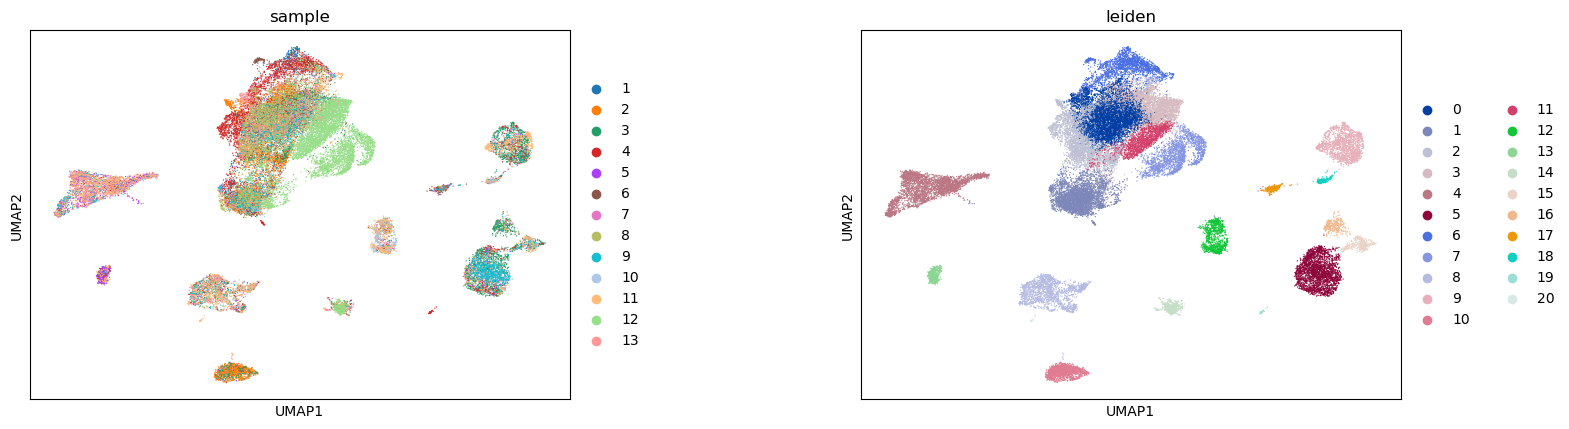

In [7]:
# Quick UMAP overview:
# - color by batch (e.g. "sample")
# - color by cluster ("louvain")
umap_colors = []

if "sample" in adata_proc.obs.columns:
    umap_colors.append("sample")

if "condition" in adata_proc.obs.columns:   # only if present in your data
    umap_colors.append("condition")

if "louvain" in adata_proc.obs.columns:
    umap_colors.append("louvain")

if "leiden" in adata_proc.obs.columns:
    umap_colors.append("leiden")

sc.pl.umap(
    adata_proc,
    color=umap_colors,
    wspace=0.4,
)


In [8]:
from scrna_pipeline.annotation import score_markers_and_suggest_labels

# ------------------------------------------------------------------
# 1) Define marker dictionary
# ------------------------------------------------------------------
marker_dict = {
    # -----------------------
    # Epithelial 
    # -----------------------
    "Epithelial": [
        "EPCAM",   # classic epithelial marker
        "KRT8",
        "KRT18",
        "KRT19",
        "KRT17",
        "KRT5",
        "KRT14",
        "MUC1",    # luminal / glandular epithelial
    ],

    # -----------------------
    # Immune lineages
    # -----------------------
    "T_cell": [
        "CD3D", "CD3E", "CD2", "CD8A", "CD4",
    ],
    "B_cell": [
        "MS4A1", "CD79A", "CD79B",
    ],
    "Myeloid": [
        "LYZ",
        "CD68", "CD14",
        "TYROBP", "LST1",
        "CSF1R", "FCGR3A",
    ],

    # -----------------------
    # Stromal + mast
    # -----------------------
    "Endothelial": [
        "PECAM1", "VWF", "KDR",
    ],
    "Fibroblast": [
        "COL1A1", "COL1A2", "DCN", "LUM",
    ],
    "Mast": [
        "TPSAB1", "TPSB2", "CPA3", "KIT", "HDC", "MS4A2",
    ],
}


# ------------------------------------------------------------------
# 2) Pick a cluster column automatically
# ------------------------------------------------------------------
if "leiden" in adata_proc.obs:
    cluster_key = "leiden"
elif "louvain" in adata_proc.obs:
    cluster_key = "louvain"
elif "cluster" in adata_proc.obs:
    # in case you manually created a generic cluster column
    cluster_key = "cluster"
else:
    raise ValueError(
        "No clustering column found in `adata.obs`. "
        "Expected one of: 'leiden', 'louvain', or 'cluster'."
    )

print(f"Using cluster_key = '{cluster_key}' for marker-based annotation.")

# ------------------------------------------------------------------
# 3) Score markers and get suggested labels
# ------------------------------------------------------------------
cluster_scores, suggested = score_markers_and_suggest_labels(
    adata_proc,
    marker_dict=marker_dict,
    cluster_key=cluster_key,
)

# ------------------------------------------------------------------
# 4) Pretty display (with fallback if styling fails)
# ------------------------------------------------------------------
try:
    display(
        cluster_scores
        .round(2)
        .style
        .background_gradient(cmap="viridis")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            dict(selector="th", props=[("text-align", "center")]),
        ])
    )
except Exception as e:
    # e.g. jinja2 not installed or in non-notebook context
    print("Styled display failed, showing plain table instead:", repr(e))
    display(cluster_scores.round(2))

# If you want, you can also inspect the suggested labels:
suggested


Using cluster_key = 'leiden' for marker-based annotation.


/Users/alahi.irfan/Desktop/Local_workspace/scRNA-seq-pipeline/scrna_pipeline/annotation.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cluster_key)[score_cols]


,Epithelial,T_cell,B_cell,Myeloid,Endothelial,Fibroblast,Mast
leiden,,,,,,,
0,0.110000,-0.140000,-0.040000,-0.160000,-0.160000,-0.070000,-0.160000
1,0.110000,-0.060000,-0.010000,-0.060000,-0.080000,-0.030000,-0.050000
2,0.090000,-0.110000,-0.030000,-0.130000,-0.130000,-0.060000,-0.110000
3,0.040000,-0.140000,-0.040000,-0.170000,-0.160000,-0.070000,-0.150000
4,-0.200000,0.930000,0.010000,-0.030000,-0.100000,-0.040000,-0.120000
5,-0.250000,-0.120000,-0.060000,-0.130000,1.250000,-0.070000,-0.160000
6,0.240000,-0.150000,-0.050000,-0.060000,-0.170000,-0.070000,-0.200000
7,0.080000,-0.130000,-0.040000,-0.170000,-0.160000,-0.070000,-0.170000
8,-0.230000,0.100000,-0.030000,1.420000,-0.050000,-0.060000,-0.120000


leiden
0      Epithelial
1      Epithelial
2      Epithelial
3      Epithelial
4          T_cell
5     Endothelial
6      Epithelial
7      Epithelial
8         Myeloid
9      Fibroblast
10           Mast
11     Epithelial
12     Epithelial
13         B_cell
14     Epithelial
15    Endothelial
16    Endothelial
17     Fibroblast
18     Fibroblast
19    Endothelial
20     Epithelial
dtype: object

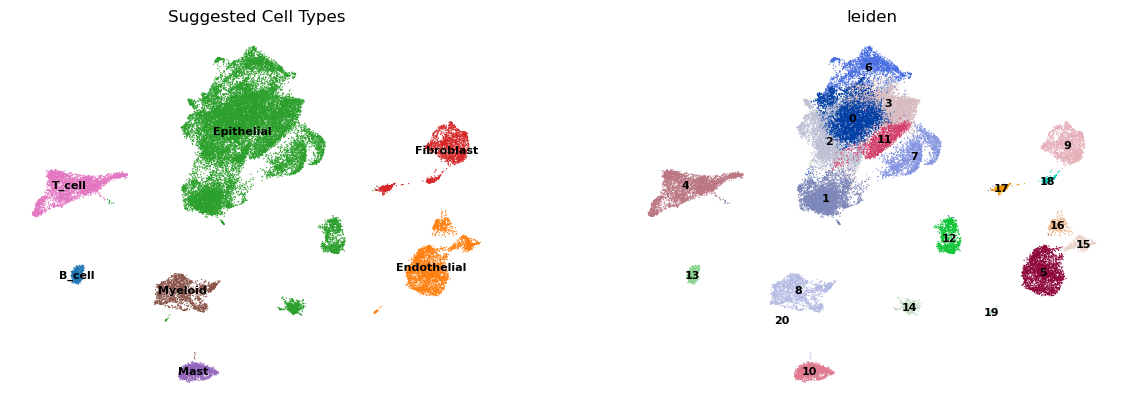

In [9]:


# Attach suggested labels for plotting
adata_proc.obs["celltype"] = adata_proc.obs[cluster_key].map(suggested)


sc.pl.umap(
    adata_proc,
    color=["celltype",cluster_key],
    legend_loc="on data",
    legend_fontsize=8,
    frameon=False,
    title="Suggested Cell Types",
)